# DL-Ops Assignment 3: layer-wise pretraining

## Checking Avilable GPU

In [13]:
!nvidia-smi

Tue Feb 28 23:27:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.78.01    Driver Version: 525.78.01    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   56C    P5   119W / 350W |   6079MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [14]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

try:
  import torchattacks
except:
  !pip3 -q install torchattacks
finally:
  import torchattacks

## device agnostic code

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Model Defination

In [16]:
class LayerWisePreTrainedCLF(nn.Module):
  def __init__(
      self,
      in_channels:int,
      hidden_units:int
      ) -> None:
    '''
    args:
      in_channels: input image shape
      hidden_units: number of hidden in neural net.
      out_channels: number of classes in the data
      is_train_encoder: true if training encoder and not clf.
    '''
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_channels * 96 * 96, hidden_units), # layer 1
      nn.ReLU()
    )

  def forward(self, x):
    x = self.block_1(x)
    return x

In [17]:
model_lw_pre = LayerWisePreTrainedCLF(in_channels=3,hidden_units=1024)

## Model summary

In [18]:
summary(model=model_lw_pre,
        input_size=(32,3,96,96),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
LayerWisePreTrainedCLF (LayerWisePreTrainedCLF)    [32, 3, 96, 96]      [32, 1024]           --                   True
├─Sequential (block_1)                             [32, 3, 96, 96]      [32, 1024]           --                   True
│    └─Flatten (0)                                 [32, 3, 96, 96]      [32, 27648]          --                   --
│    └─Linear (1)                                  [32, 27648]          [32, 1024]           28,312,576           True
│    └─ReLU (2)                                    [32, 1024]           [32, 1024]           --                   --
Total params: 28,312,576
Trainable params: 28,312,576
Non-trainable params: 0
Total mult-adds (M): 906.00
Input size (MB): 3.54
Forward/backward pass size (MB): 0.26
Params size (MB): 113.25
Estimated Total Size (MB): 117.05

## Getting Dataset with pytorch

### Downloading Dataset

In [28]:
from torchvision import transforms

# define transforms
transform = transforms.Compose([
        # transforms.Resize((224,224)),
        transforms.ToTensor(),
])


train_dataset = torchvision.datasets.STL10(
    root='data',
    split='train',
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.STL10(
    root='data',
    split='test',
    download=True,
    transform=transform
)
train_dataset, test_dataset


Files already downloaded and verified
Files already downloaded and verified


(Dataset STL10
     Number of datapoints: 5000
     Root location: data
     Split: train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset STL10
     Number of datapoints: 8000
     Root location: data
     Split: test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

### Vis. dataset (train dataset)

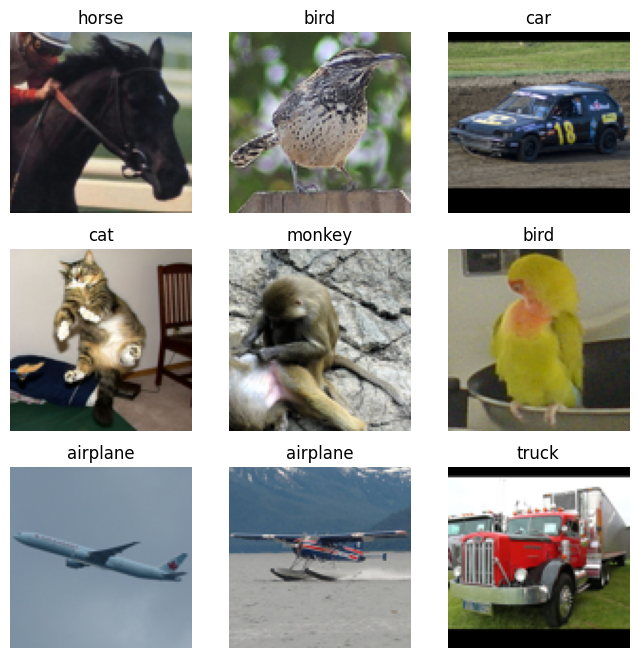

In [29]:
# randomly ploting image samples from the grayscale dataset
classes = train_dataset.classes
labels_map = {i:j for i,j in zip(classes,range(len(classes)))} # getting class -> index map
labels_map = dict(map(reversed, labels_map.items()))  # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(8, 8))  # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(
        len(train_dataset), size=(1,)
    )  # randomely selecting one image sample from the image index
    img, label = train_dataset[sample_idx]  # getting image and label of selected index
    # sub plot code
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(
        img.permute(1, 2, 0)
    )  # NOTE:- Color map is gray because we're converting imgae to grayscale / changing channel to HWC for color image
    # sub plot code ends
plt.show()
# NOTE: WARRING BECAUSE OF auto_transforms

### Converting dataset to dataloader

In [30]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()  # no. of avilable cpu cores

# train dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader

Numbers of Batches in Train Dataloader: 157
Numbers of Batches in Test Dataloader: 250


## Models Training

### Plot loss curves of a model

In [22]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

### making training, testing steps, train model functions

#### set seeds function

In [23]:
### set seed function
def set_seed(seed: int = 42):
    """
    sets mannual seeds for both cpu and cuda
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


#### train step

In [24]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss, train_acc = 0, 0  # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for (X, y) in dataloader:  # loop in batches
        # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        # y_pred = y_pred_logits.argmax(dim=1).type(torch.int)
        # print(y_pred)
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # model_parms_after_forward_pass = np.array([x.detach().numpy() for x in model.parameters()])
        # print("Model parms diff:")
        # print([(i,j) for (i,j) in zip(iter(model_parms_after_forward_pass),iter(model_parms_before_forward_pass))])
        # print(model_parms_after_forward_pass - model_parms_before_forward_pass,sep="\n")
        train_acc += acc_fn(y_pred_logits.argmax(dim=1), y).item()

    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader), train_acc / len(dataloader)


#### test step

In [25]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss, test_acc = 0, 0  # initlizing loss and acc. for the epoch

    # with torch.inference_mode(): # disabling inference mode for aqcuiring gradients of perturbed data
    for (X, y) in dataloader:  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # printing the prediction and actual label
        # print(y_pred_logits.argmax(dim=1), y,sep='\n')
        
        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits.argmax(dim=1), y).item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader), test_acc / len(dataloader)

#### training function

In [26]:
from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    save_interval:int =10,
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      epochs (int): number of epochs to train the model
      save_interval (int): interval to save the model
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
        )

        test_loss, test_acc = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )
        # saving the model after every save_interal epochs
        if (epoch+1) % save_interval == 0:
            torch.save(model.state_dict(), f"models/model_{epoch+1}.pth")
        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)

    # 5. return result dict
    return result_dict


### Training the model layers and adding to the model

In [32]:
import os
import torch
from torch import nn
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torchvision import transforms
from collections import OrderedDict
from accelerate import Accelerator



class LayerConfigurableMLP(nn.Module):
  '''
    Layer-wise configurable Multilayer Perceptron.
  '''
  def __init__(self, added_layers = 0,index:int=0):
    super().__init__()

    # Retrieve model configuration
    config = get_model_configuration()
    shape = config.get("width") * config.get("height") * config.get("channels")
    layer_dim = config.get("layer_dims")[index]
    num_classes = config.get("num_classes")

    # Create layer structure
    layers = [
      (str(0), nn.Flatten()),
      (str(1), nn.Linear(shape, layer_dim)),
      (str(2), nn.ReLU())
    ]

    # Create output layers
    layers.append((str(3), nn.Linear(layer_dim, num_classes)))

    # Initialize the Sequential structure
    self.layers = nn.Sequential(OrderedDict(layers))


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)


  def set_structure(self, layers):
    self.layers = nn.Sequential(OrderedDict(layers))


def get_global_configuration():
    """ Retrieve configuration of the training process. """

    global_config = {
      "num_layers_to_add": 5,
    }

    return global_config


def get_model_configuration():
    """ Retrieve configuration for the model. """

    model_config = {
      "width": 96,
      "height": 96,
      "channels": 3,
      "num_classes": 10,
      "batch_size": 32,
      "loss_function": nn.CrossEntropyLoss,
      "optimizer": torch.optim.Adam,
      "num_epochs": 5,
      "layer_dims": [1024,1200,728,512,128],
      "layer_dim": 1024
    }

    return model_config


def get_dataset():
  """ Load and convert dataset into inputs and targets """
  config = get_model_configuration()
  dataset = STL10('data', download=True, transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=config.get("batch_size"), shuffle=True, num_workers=os.cpu_count())

  return trainloader


def add_layer(model,index=0):
  """ Add a new layer to a model, setting all others to nontrainable. """
  config = get_model_configuration()

  # Retrieve current layers
  layers = model.layers
  print("="*50)
  print("Old structure:")
  print(layers)

  # Save last layer for adding later
  if(index==0):
    print("LOG: ",layers[-1])
    last_layer = layers[-1]
  else:
    last_layer = nn.Linear(config.get("layer_dims")[index], 10)

  # Define new structure
  new_structure = []

  # Iterate over all except last layer
  for layer_index in range(len(layers) - 1):

    # For old layer, set all parameters to nontrainable
    old_layer = layers[layer_index]
    for param in old_layer.parameters():
      param.requires_grad = False

    # Append old layer to new structure
    new_structure.append((str(layer_index), old_layer))

  # Append new layer to the final intermediate layer
  if index == 0:
    new_structure.append((str(len(new_structure)), nn.Linear(1024, config.get("layer_dim"))))
  else:
    new_structure.append((str(len(new_structure)), nn.Linear(config.get("layer_dims")[index-1], config.get("layer_dims")[index])))

  # Re-add last layer
  new_structure.append((str(len(new_structure)), last_layer))

  # Change the model structure
  model.set_structure(new_structure)

  # Return the model
  print("="*50)
  print("New structure:")
  print(model.layers)

  return model




def train_model(model):
  """ Train a model. """
  config = get_model_configuration()
  loss_function = config.get("loss_function")()
  optimizer = config.get("optimizer")(model.parameters(), lr=1e-4)
  trainloader = get_dataset()
  accelerator = Accelerator()
    
  # Set current loss value
  end_loss = 0.0

  # Accelerate model
  model, optimizer, trainloader = accelerator.prepare(model, optimizer, trainloader)
  
  # Iterate over the number of epochs
  for epoch in range(config.get("num_epochs")):
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = model(inputs)
      
      # Compute loss
      loss = loss_function(outputs, targets)
      
      # Perform backward pass
      accelerator.backward(loss)
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          end_loss = current_loss / 500
          current_loss = 0.0

  # Return trained model
  return model, end_loss


def greedy_layerwise_training():
  """ Perform greedy layer-wise training. """
  global_config = get_global_configuration()
  torch.manual_seed(42)

  # Initialize the model
  model = LayerConfigurableMLP()

  # Loss comparison
  loss_comparable = 0.0

  # Iterate over the number of layers to add
  for num_layers in range(global_config.get("num_layers_to_add")):

    # Print which model is trained
    print("="*100)
    if num_layers > 0:
      print(f">>> TRAINING THE MODEL WITH {num_layers} ADDITIONAL LAYERS:")
    else:
      print(f">>> TRAINING THE BASE MODEL:")

    # Train the model
    model, end_loss = train_model(model)

    # Compare loss
    if num_layers > 0 and end_loss < loss_comparable:
      print("="*50)
      print(f">>> RESULTS: Adding this layer has improved the model loss from {loss_comparable} to {end_loss}")
      loss_comparable = end_loss
    elif num_layers > 0:
      print("="*50)
      print(f">>> RESULTS: Adding this layer did not improve the model loss.")
    elif num_layers == 0:
      loss_comparable = end_loss

    # Add layer to model
    model = add_layer(model,index=num_layers)

  # Process is complete
  print("Training process has finished.")
  return model
  
model = greedy_layerwise_training().to(device)
  

>>> TRAINING THE BASE MODEL:
Files already downloaded and verified
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Old structure:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=27648, out_features=1024, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=10, bias=True)
)
LOG:  Linear(in_features=1024, out_features=10, bias=True)
New structure:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=27648, out_features=1024, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): Linear(in_features=1024, out_features=10, bias=True)
)
>>> TRAINING THE MODEL WITH 1 ADDITIONAL LAYERS:
Files already downloaded and verified
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
>>> RESULTS: Adding this layer did not improve the model loss.
Old structure:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear

In [38]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

def plot_conf_matrix(model, test_loader):
    y_test_ls = []
    y_pred_ls = []

    model.eval()

    with torch.inference_mode():
        for X_test, y_test in test_loader:
            test_pred = model(X_test)

            y_pred = test_pred.argmax(dim = 1)

            for pred, true in zip(y_pred, y_test):
                y_pred_ls.append(pred)
                y_test_ls.append(true)


    confusion_mat = confusion_matrix(y_test_ls, y_pred_ls)

    fig, ax = plot_confusion_matrix(conf_mat=confusion_mat,
                                    colorbar=True,
                                    show_absolute=False,
                                    show_normed=True)
    plt.show()

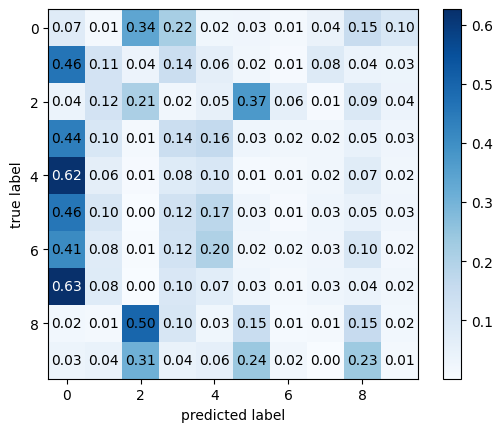

In [40]:
plot_conf_matrix(model.to("cpu"), test_dataloader)